# Module: Deep Learning - Computer Vision

## Section: Transfer Learning

## <font color='#4073FF'>Project Solution: Covid - 19 prediction using chest images.</font>

###  <font color='#14AAF5'>The objective of this project is to use transfer learning to classify if a person has Covid-19, Viral Pneumonia or has none of them. </font>

### Project Brief:

The COVID-19 pandemic has led to a dramatic loss of human life worldwide and presents an unprecedented challenge to public health, food systems and the world of work. It is important to detect the positive cases as early as possible to prevent the further spread of this pandemic. AI-based X-ray screening is a promising approach for COVID-19 testing in both symptomatic and asymptomatic patients.  However, a unique challenge for algorithms is to be able to distinguish between COVID-19 versus other lower respiratory diseases which may look similar in X-ray imagery.

### 1. Dataset

The COVID-19 Chest X-ray data is collected by Dr. Joseph Paul Cohen of the University of Montreal. This dataset consists of posterior-anterior chest images of patients with pneumonia. The dataset was split into 3 different categories: Normal, Pneumonia (Viral) and Pneumonia (COVID-19). The train data consists of around 250 images, while the test data consists of 66 images.

In [1]:
# Importing Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

### 2.  Data collection into train, validation and test sets

#### Pre-processing and Loading Data

As one might have observed, real datasets are a little messy to work with. We have variety of image formats in our data and most of these images are of different sizes. Thus, we should preprocess them in a way that all of them are of the same size. Futher, scaling them can improve model performance. There are other parameters such as shear_range, zoom_range and horizontal_flip which are also used. We might also want to divide the train data into train and validation sets. The test data can be used to check how machine predicts on unknown data.

Learn more:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator 

In [2]:
# Importing Required Libraries

import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [3]:
# Preprocessing and loading The Data into train, validation and test sets

data = ImageDataGenerator(
                          validation_split = 0.25, 
                          rescale=1./255, 
                          shear_range=0.2,
                          zoom_range=0.2, 
                          horizontal_flip=True 
                          )
batch_size=32

traindata = data.flow_from_directory(directory="Covid19-dataset/train/",
                                     target_size = (256,256),
                                     batch_size = batch_size,
                                     class_mode = 'categorical',
                                     subset  = 'training',
                                     shuffle = True
                                     )
validationdata = data.flow_from_directory(directory="Covid19-dataset/train/",
                                     target_size = (256,256),
                                     batch_size = batch_size,
                                     class_mode = 'categorical',
                                     subset  = 'validation',
                                     shuffle = True
                                     )


testdata = data.flow_from_directory(directory = "Covid19-dataset/test/",
                                   target_size = (256,256),
                                   batch_size = batch_size,
                                   class_mode = 'categorical',
                                   shuffle = False
                                   )

Found 190 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


### 3. Exploring data

In [4]:
# Viewing class labels

traindata.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

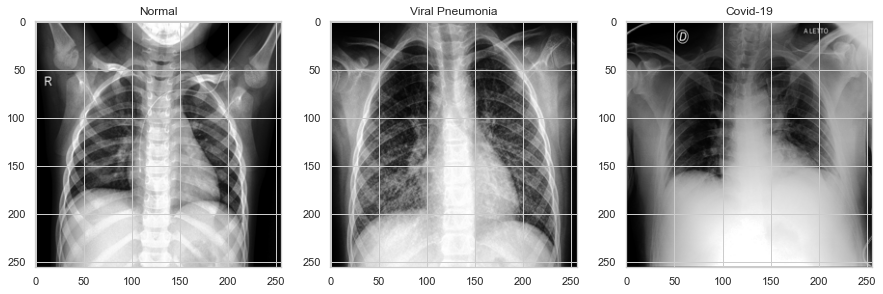

In [5]:
# Viewing images

from PIL import Image

fig,ax = plt.subplots(1,3,figsize=(15,7))

# Normal Image
img = Image.open(r"Covid19-dataset\train\Normal\01.jpeg")
ax[0].imshow(img.resize((256,256)))
ax[0].title.set_text("Normal")

# Viral Pneumonia
img1 = Image.open(r"Covid19-dataset\train\Viral Pneumonia\01.jpeg")
ax[1].imshow(img1.resize((256,256)))
ax[1].title.set_text("Viral Pneumonia")

# Covid Image
img = Image.open(r"Covid19-dataset\train\Covid\012.jpeg")
ax[2].imshow(img.resize((256,256)))
ax[2].title.set_text("Covid-19")

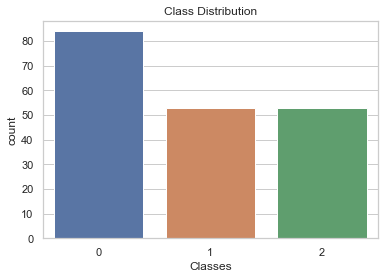

In [6]:
# 3 Classes
sns.countplot(x=traindata.classes)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.show()

### 4. Modelling a neural network

#### **Methodology – Transfer Learning (ResNet50V2 with some custom layers)** 

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

That means, taking the relevant parts of a pre-trained machine learning model and applying it to a new but similar problem. This will usually be the core information for the model to function, with new aspects added to the model to solve a specific task.The main benefits of transfer learning include the saving of resources and improved efficiency when training new models. It can also help with training models when only unlabelled datasets are available, as the bulk of the model will be pre-trained.

##### ResNet50V2

In [7]:
from tensorflow.keras.layers import Input,Flatten,Dense,Conv2D,MaxPooling2D

#ResNet50V2
Res50V2 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Setting trainable false
for layer in Res50V2.layers:
    layer.trainable = False

# Adding some custom layers
x = Conv2D(128, (3, 3), activation='relu')(Res50V2.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(traindata.num_classes,activation='softmax')(x)

model = models.Model(inputs=Res50V2.input, outputs=x)

In [8]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 64, 64, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 64, 64, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 32, 32, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 32, 32, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 16, 16, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 18, 18, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 16, 16, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 16, 16, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 18, 18, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 8, 8, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 8, 8, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 8, 8, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 8, 8, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 8, 8, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

In [9]:
#Compiling the model

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

stepsTrain = (traindata.n // batch_size) 
stepsVal = (validationdata.n // batch_size) 


#### Fitting the model

In [10]:
#Model Fitting ,training for 10 epochs
history = model.fit(traindata, epochs=10, validation_data=validationdata,
          steps_per_epoch=stepsTrain, validation_steps=stepsVal)

Epoch 1/10
5/5 [==============================] - 25s 5s/step - loss: 1.6478 - accuracy: 0.4873 - val_loss: 1.0207 - val_accuracy: 0.6250
Epoch 2/10
5/5 [==============================] - 20s 4s/step - loss: 0.4064 - accuracy: 0.8291 - val_loss: 0.8076 - val_accuracy: 0.7500
Epoch 3/10
5/5 [==============================] - 19s 4s/step - loss: 0.3106 - accuracy: 0.8750 - val_loss: 0.6511 - val_accuracy: 0.7812
Epoch 4/10
5/5 [==============================] - 20s 4s/step - loss: 0.1795 - accuracy: 0.9430 - val_loss: 0.3673 - val_accuracy: 0.8750
Epoch 5/10
5/5 [==============================] - 20s 4s/step - loss: 0.1477 - accuracy: 0.9241 - val_loss: 0.4738 - val_accuracy: 0.8750
Epoch 6/10
5/5 [==============================] - 20s 4s/step - loss: 0.1308 - accuracy: 0.9430 - val_loss: 0.6747 - val_accuracy: 0.7812
Epoch 7/10
5/5 [==============================] - 20s 4s/step - loss: 0.0869 - accuracy: 0.9747 - val_loss: 0.5018 - val_accuracy: 0.8438
Epoch 8/10
5/5 [==================

### 5. Evaluating the model

In [11]:
from sklearn.metrics import classification_report,accuracy_score



#classification report
names = testdata.class_indices.keys()
Y_pred = model.predict(testdata,steps = len(testdata.filenames)/batch_size)
y_pred = np.argmax(Y_pred, axis=1)



print('Classification Report')
target_names = testdata.class_indices.keys()
print(classification_report(testdata.classes, y_pred, target_names=target_names))



print('Accuracy on test set',round(accuracy_score(testdata.classes,y_pred),2))

Classification Report
                 precision    recall  f1-score   support

          Covid       1.00      0.85      0.92        26
         Normal       0.85      0.85      0.85        20
Viral Pneumonia       0.79      0.95      0.86        20

       accuracy                           0.88        66
      macro avg       0.88      0.88      0.88        66
   weighted avg       0.89      0.88      0.88        66

Accuracy on test set 0.88


### 6. Export the model for deployment

In [12]:
# Export the model for deployment
from keras.models import load_model

model.save('my_transfer_learning_model1.h5')